# 1. Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD

import math

# 2. Loading datasets
`Loading datasets and preforming basic checks for better understanding and operability`

In [2]:
# Loading Category and item properties dataset
category=pd.read_csv(r"F:\DataSets\Recommendation system\category_tree.csv")
item_properties1=pd.read_csv(r"F:\DataSets\Recommendation system\item_properties_part1.csv")
item_properties2=pd.read_csv(r"F:\DataSets\Recommendation system\item_properties_part2.csv")


In [3]:
category.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [4]:
item_properties1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [5]:
item_properties2.head()

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [6]:
# Item properties dataset can be combined together
items=pd.concat([item_properties1,item_properties2])
items

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
9275898,1433646000000,236931,929,n12.000
9275899,1440903600000,455746,6,150169 639134
9275900,1439694000000,347565,686,610834
9275901,1433646000000,287231,867,769062


# 3. EDA

In [7]:
items.shape

(20275902, 4)

In [8]:
items.isna().sum() #checking for presence of null values

timestamp    0
itemid       0
property     0
value        0
dtype: int64

In [9]:
items.duplicated().sum()  # Checking duplicate values

0

In [10]:
items.nunique() 

timestamp         18
itemid        417053
property        1104
value        1966868
dtype: int64

In [11]:
# To run things faster We will perform on 1-lacs unique items,
# so we've taken random choice from items data.

np.random.seed(1)
items_to_keep = np.random.choice(items['itemid'].unique(), size=100000, replace=False)
items = items[items['itemid'].isin(items_to_keep)]

In [12]:
items=items.sort_values('timestamp')
items

,timestamp,itemid,property,value
3731462,1431226800000,169750,888,236638 1318760 1251992
3436537,1431226800000,197448,6,321215
3436536,1431226800000,90849,categoryid,3
2806356,1431226800000,105892,678,1301021
5831169,1431226800000,185060,764,1285872
...,...,...,...,...
5886180,1442113200000,327568,776,938669
5886031,1442113200000,307494,208,769062 414047 1078259
2238697,1442113200000,335781,888,789070 992862 951748 685028 713663 n28.800 113...
5884406,1442113200000,54794,categoryid,126


In [13]:
# This takes only last event in value column , it helps in simplifying the data by dropping the changes over time
items=items.groupby(['itemid','property'])['value'].last().reset_index()
items

,itemid,property,value
0,3,1025,769062
1,3,1080,769062
2,3,112,679677
3,3,159,519769
4,3,202,261419
...,...,...,...
2879852,466864,888,1262739 205682 1050016 1154859
2879853,466864,917,205682
2879854,466864,928,1154859
2879855,466864,available,0


In [14]:
items.nunique()

itemid      100000
property      1082
value       526372
dtype: int64

In [15]:
events_df=pd.read_csv(r"F:\DataSets\Recommendation system\events.csv")

In [16]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [17]:
final_events_df = events_df[events_df['itemid'].isin(items_to_keep)]
final_events_df = final_events_df.sort_values(['visitorid', 'timestamp']).reset_index(drop=True)

In [18]:
final_events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1438970212664,2,view,259884,NaN
1,1438413035296,3,view,385090,NaN
2,1438713029611,10,view,248766,NaN
3,1430668212744,12,view,70225,NaN
4,1434602595136,13,view,278689,NaN


In [19]:
final_events_df.nunique()

timestamp        606154
visitorid        375331
event                 3
itemid            44358
transactionid      4995
dtype: int64

In [20]:
final_events_df['event'].value_counts()

event
view           584488
addtocart       16598
transaction      5488
Name: count, dtype: int64

In [21]:
final_events_df['event'].value_counts(normalize=True)

event
view           0.963589
addtocart      0.027364
transaction    0.009048
Name: proportion, dtype: float64

In [22]:
# the most bought items are
final_events_df['itemid'].value_counts().head()


itemid
257040    1647
96924     1633
234255    1307
151444    1230
9877      1162
Name: count, dtype: int64

In [23]:
# Most active Customers
final_events_df['visitorid'].value_counts().head()

visitorid
1150086    1722
530559      904
152963      737
895999      639
163561      594
Name: count, dtype: int64

In [24]:
final_events_df.dtypes

timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
dtype: object

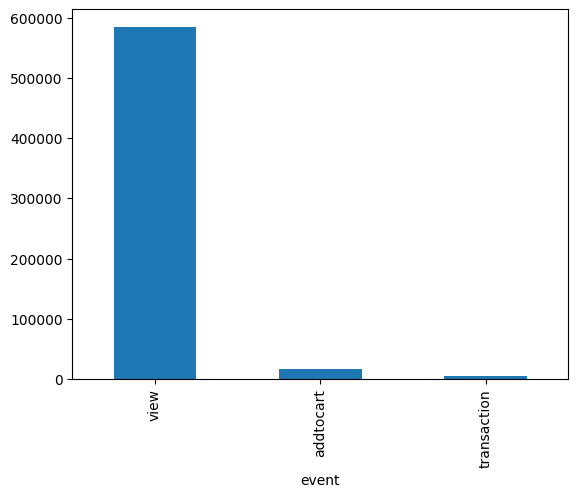

In [25]:
final_events_df['event'].value_counts().plot.bar()
plt.show()


# 4. User based collaborative system

In [26]:
final_events_df['event'].unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

In [27]:
final_events_df["event"].size

606574

In [28]:
final_events_df["itemid"].size

606574

In [29]:
final_events_df["itemid"].unique().size

44358

In [30]:
# Checking total transactions
final_events_df["transactionid"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
606569   NaN
606570   NaN
606571   NaN
606572   NaN
606573   NaN
Name: transactionid, Length: 606574, dtype: float64

In [31]:
final_events_df["transactionid"].isna().value_counts()

transactionid
True     601086
False      5488
Name: count, dtype: int64

In [32]:
final_events_df.dropna()

,timestamp,visitorid,event,itemid,transactionid
102,1439602141230,172,transaction,465522,9725.0
111,1439397297040,186,transaction,49029,8726.0
333,1439244127846,795,transaction,207825,14460.0
443,1435346930661,1032,transaction,243949,9747.0
949,1434339796245,2242,transaction,402047,4407.0
...,...,...,...,...,...
604917,1437861768997,1403465,transaction,322887,14986.0
605323,1437580443035,1404233,transaction,350960,8846.0
605593,1435010291668,1404991,transaction,250640,17090.0
605877,1432083506552,1405861,transaction,182785,1603.0


In [33]:
final_events_df['transactionid'].dropna().size

5488

In [34]:
# Distinct transaction
final_events_df['transactionid'].unique().size

4996

In [35]:
# Customer who purchased items
customer_purchase = final_events_df[final_events_df.transactionid.notnull()].visitorid.unique().size
customer_purchase

3453

In [36]:
# Customer who not bought any items
customer_not_purchase = final_events_df[final_events_df.transactionid.isnull()].visitorid.unique().size
customer_not_purchase

375294

In [37]:
pd.DataFrame(final_events_df["transactionid"].value_counts())

,count
transactionid,
8351.0,10
7063.0,9
765.0,8
2753.0,6
2376.0,5
...,...
1363.0,1
14030.0,1
17261.0,1


In [38]:
# total number of customers who visted site
final_events_df['visitorid'].size

606574

In [39]:
# number of unique customers
final_events_df["visitorid"].unique().size

375331

In [40]:
pd.DataFrame(final_events_df["visitorid"].value_counts())

,count
visitorid,
1150086,1722
530559,904
152963,737
895999,639
163561,594
...,...
531743,1
531741,1
531737,1


In [41]:
top_items = pd.DataFrame(final_events_df['itemid'].value_counts())[:2000]
top_items

,count
itemid,
257040,1647
96924,1633
234255,1307
151444,1230
9877,1162
...,...
359336,60
345569,60
14387,60


In [42]:
customer_item = pd.DataFrame(final_events_df.groupby(['visitorid','itemid','event'])['timestamp'].count().reset_index())
customer_item


,visitorid,itemid,event,timestamp
0,2,259884,view,1
1,3,385090,view,1
2,10,248766,view,1
3,12,70225,view,1
4,13,278689,view,1
...,...,...,...,...
482371,1407566,357369,view,1
482372,1407572,122041,view,2
482373,1407573,57720,view,1
482374,1407573,116453,view,1


In [43]:
customer_item_df = customer_item[customer_item['event'] == 'addtocart']
customer_item_df.head()

,visitorid,itemid,event,timestamp
43,150,452955,addtocart,1
50,155,389974,addtocart,1
58,172,465522,addtocart,2
67,186,49029,addtocart,1
100,299,149253,addtocart,1


In [44]:
customer_item_df = customer_item_df[customer_item_df['itemid'].isin(top_items.index)]
customer_wise_df = customer_item_df.pivot(index='visitorid', columns='itemid', values='timestamp')
customer_wise_df

itemid,315,496,1845,1891,2331,2463,2711,2750,3656,4246,...,465554,465951,466008,466109,466259,466385,466436,466472,466726,466864
visitorid,,,,,,,,,,,,,,,,,,,,,
150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1406831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1407059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
customer_wise_df = customer_wise_df.fillna(0)
customer_wise_df.head()

itemid,315,496,1845,1891,2331,2463,2711,2750,3656,4246,...,465554,465951,466008,466109,466259,466385,466436,466472,466726,466864
visitorid,,,,,,,,,,,,,,,,,,,,,
150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
item_wise_df = customer_wise_df.T
item_wise_df

visitorid,150,172,299,318,648,795,878,904,1032,1399,...,1405861,1406064,1406198,1406417,1406488,1406518,1406831,1407059,1407070,1407319
itemid,,,,,,,,,,,,,,,,,,,,,
315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# USER to USER Similarities
user_similarities = cosine_similarity(customer_wise_df)
user_based_cosine_similarity_df = pd.DataFrame(user_similarities, index=customer_wise_df.index.values, columns=customer_wise_df.index.values)
user_based_cosine_similarity_df

,150,172,299,318,648,795,878,904,1032,1399,...,1405861,1406064,1406198,1406417,1406488,1406518,1406831,1407059,1407070,1407319
150,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
648,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1406831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1407059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1407070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [51]:
customer_wise_similarity = pd.DataFrame(user_based_cosine_similarity_df.loc[299].sort_values(ascending=False))
customer_wise_similarity.head(30)

,299
804876,1.000000
299,1.000000
552564,1.000000
879563,1.000000
358516,0.707107
548772,0.277350
952246,0.242536
757355,0.162221
938747,0.000000
941074,0.000000


In [52]:
# ITEM to ITEM Similarities
items_similarities = cosine_similarity(item_wise_df)
item_wise_cosine_similarity_df = pd.DataFrame(items_similarities, index=item_wise_df.index.values, columns=item_wise_df.index.values)
item_wise_cosine_similarity_df

,315,496,1845,1891,2331,2463,2711,2750,3656,4246,...,465554,465951,466008,466109,466259,466385,466436,466472,466726,466864
315,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1845,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1891,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2331,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
466436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
466472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
466726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [53]:
item_wise_similarity = pd.DataFrame(item_wise_cosine_similarity_df.loc[465554].sort_values(ascending=False))
item_wise_similarity.head(10)

,465554
465554,1.000000
268784,0.500000
195490,0.288675
82340,0.288675
424421,0.182574
314073,0.000000
316244,0.000000
316183,0.000000
315756,0.000000
315571,0.000000


In [57]:
# Suggestion For particular customer
suggestion_for_customer = 299
items_rated_by_customer = pd.DataFrame(final_events_df[(final_events_df['visitorid']==suggestion_for_customer)]['itemid'].unique())
items_rated_by_customer

,0
0,416219
1,149253


In [60]:

import pickle

# Save user similarity matrix
user_based_cosine_similarity_df.to_pickle('models/user_similarities.pkl')

# Save item similarity matrix
item_wise_cosine_similarity_df.to_pickle('models/item_similarities.pkl')

# Save customer interaction data
final_events_df.to_pickle('models/interaction_data.pkl')
